In [1]:
import sys
sys.path.append("..\\methods")

In [2]:
import os

from estnltk import Text

import json
from estnltk.converters import json_to_text

from noun_phrase_extraction import create_df
from POS_sequence import get_POS_sequence
from graph_methods import *

import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout

import pandas as pd
import numpy as np

In [3]:
path = 'json_data/'

In [4]:
all_texts = []

for filename in os.listdir(path):
    file = os.path.join(path, filename)
    with open(file, 'r') as f:
        content = json.load( f )
        text = json_to_text( content )
        all_texts.append( text )

In [5]:
all_texts[0]

Text(text='ALBERT LAEGAS , Tallinn\n\nMinu arvates on parlamenti mittekuuluvate erakondade nõue korraldada uued parlamendivalimised täiesti õigel kohal .\nJärgmine samm oleks konstitutsiooniparandus , mille kohaselt saaksid parlamenti kuuluda vaid sinna mittekuuluvad parteid .\nSee tähendaks , et kõigepealt oleks valimised , misjärel kõik valimistel kaotanud jõud moodustaksid võimuloleva parlamendi .\nNii oleks Eesti valitsuses esindatud kõik vähemused : mitte ainult nö. tavalised vähemused , vaid ka tegelikud poliitilised vähemused .\n\nMinu teada pole veel ükski riik demokraatia arengus nii kaugele jõudnud .\nEesti riik peab aga sammuma esireas ja veelgi eespool .')

In [6]:
for text_id, text in enumerate(all_texts):
    df = create_df(text_id, text)

In [7]:
df

,phrase,text_id,start_end,phrase_type,has_ner_entity,has_timex_entity
0,Text(text='Minu'),0,"(25, 29)",obl_phrase,0,0
1,Text(text='täiesti õigel kohal'),0,"(119, 138)",obl_phrase,0,0
2,Text(text='mille kohaselt'),0,"(187, 201)",obl_phrase,0,0
3,Text(text='parlamenti'),0,"(210, 220)",obl_phrase,0,0
4,Text(text='valimistel'),0,"(326, 336)",obl_phrase,0,0
...,...,...,...,...,...,...
25128,"Text(text='See on puhas strateegiline küsimus - kui ma suudan anda teatrile natukene raha , siis lavastajatel on seda suurem võimalus eksida .')",145,"(3220, 3351)",root_phrase,0,0
25129,Text(text='Eestis on harilikult kombeks sõita mõnele festivalile .'),145,"(4353, 4408)",root_phrase,1,0
25130,Text(text='Aga publikule ?'),145,"(4692, 4707)",root_phrase,0,0
25131,"Text(text='Minu meelest on see irdidee , et me kohutavalt müüma hakkame .')",145,"(4734, 4796)",root_phrase,0,0


### POS-märgendite järjestused

Lisame kõik sõnaliigijärjestused DataFrame-i:

In [8]:
all_pos = []
for phrase in df['phrase']:
    all_pos.append(get_POS_sequence(phrase))
df.insert(len(df.columns), 'pos_sequence', all_pos)

In [9]:
df

,phrase,text_id,start_end,phrase_type,has_ner_entity,has_timex_entity,pos_sequence
0,Text(text='Minu'),0,"(25, 29)",obl_phrase,0,0,P
1,Text(text='täiesti õigel kohal'),0,"(119, 138)",obl_phrase,0,0,D-A-S-
2,Text(text='mille kohaselt'),0,"(187, 201)",obl_phrase,0,0,P-K
3,Text(text='parlamenti'),0,"(210, 220)",obl_phrase,0,0,S
4,Text(text='valimistel'),0,"(326, 336)",obl_phrase,0,0,S
...,...,...,...,...,...,...,...
25128,"Text(text='See on puhas strateegiline küsimus - kui ma suudan anda teatrile natukene raha , siis lavastajatel on seda suurem võimalus eksida .')",145,"(3220, 3351)",root_phrase,0,0,P-V-A-A-S-Z-(J|D)-P-V-V-S-D-S-Z-J-S-V-P-C-S-V-Z
25129,Text(text='Eestis on harilikult kombeks sõita mõnele festivalile .'),145,"(4353, 4408)",root_phrase,1,0,H-V-D-S-V-P-S-Z
25130,Text(text='Aga publikule ?'),145,"(4692, 4707)",root_phrase,0,0,J-S-Z
25131,"Text(text='Minu meelest on see irdidee , et me kohutavalt müüma hakkame .')",145,"(4734, 4796)",root_phrase,0,0,P-K-V-P-S-Z-J-P-D-V-V-Z


### Süntaksipuu graafi esitus

In [20]:
test_phrase = df['phrase'][2000]

In [21]:
test_phrase.stanza_syntax

Layer(name='stanza_syntax', attributes=('id', 'lemma', 'upostag', 'xpostag', 'feats', 'head', 'deprel', 'deps', 'misc', 'parent_span', 'children'), spans=SL[Span('Indrek', [{'id': 1, 'lemma': 'Indrek', 'upostag': 'H', 'xpostag': 'H', 'feats': OrderedDict([('sg', 'sg'), ('n', 'n')]), 'head': 0, 'deprel': 'root', 'deps': '_', 'misc': '_', 'parent_span': None, 'children': <class 'tuple'>}]),
Span('ja', [{'id': 2, 'lemma': 'ja', 'upostag': 'J', 'xpostag': 'J', 'feats': OrderedDict(), 'head': 3, 'deprel': 'cc', 'deps': '_', 'misc': '_', 'parent_span': <class 'estnltk_core.layer.span.Span'>, 'children': ()}]),
Span('Ramilda', [{'id': 3, 'lemma': 'Ramilda', 'upostag': 'H', 'xpostag': 'H', 'feats': OrderedDict([('sg', 'sg'), ('n', 'n')]), 'head': 1, 'deprel': 'conj', 'deps': '_', 'misc': '_', 'parent_span': <class 'estnltk_core.layer.span.Span'>, 'children': <class 'tuple'>}]),
Span('(', [{'id': 4, 'lemma': '(', 'upostag': 'Z', 'xpostag': 'Z', 'feats': OrderedDict(), 'head': 5, 'deprel': 'punct', 'deps': '_', 'misc': '_', 'parent_span': <class 'estnltk_core.layer.span.Span'>, 'children': ()}]),
Span('Marika', [{'id': 5, 'lemma': 'Marika', 'upostag': 'H', 'xpostag': 'H', 'feats': OrderedDict([('sg', 'sg'), ('n', 'n')]), 'head': 3, 'deprel': 'parataxis', 'deps': '_', 'misc': '_', 'parent_span': <class 'estnltk_core.layer.span.Span'>, 'children': <class 'tuple'>}]),
Span('Barabantshikova', [{'id': 6, 'lemma': 'Barabantshikova', 'upostag': 'H', 'xpostag': 'H', 'feats': OrderedDict([('sg', 'sg'), ('n', 'n')]), 'head': 5, 'deprel': 'flat', 'deps': '_', 'misc': '_', 'parent_span': <class 'estnltk_core.layer.span.Span'>, 'children': ()}]),
Span(')', [{'id': 7, 'lemma': ')', 'upostag': 'Z', 'xpostag': 'Z', 'feats': OrderedDict(), 'head': 5, 'deprel': 'punct', 'deps': '_', 'misc': '_', 'parent_span': <class 'estnltk_core.layer.span.Span'>, 'children': ()}])])

Graafi koostamisel on võetud eeskuju siit: https://github.com/estnltk/syntax_experiments/blob/subcat/obl_data_experiments/data_helpers/syntax_graph.py

In [22]:
test_graph = create_graph_with_all_attributes(test_phrase)

In [23]:
test_graph_with_ids = create_graph_with_ids(test_phrase)

In [24]:
test_graph_with_pos = create_graph_with_POS(test_phrase)

In [25]:
test_graph_with_ner_timex = create_graph_with_ner_timex(test_phrase)

In [26]:
test_graph.nodes(data=True)

NodeDataView({1: {'id': 1, 'lemma': 'Indrek', 'pos': 'H', 'deprel': 'root', 'form': 'Indrek', 'feats': OrderedDict([('sg', 'sg'), ('n', 'n')]), 'start': 0, 'end': 6}, 0: {}, 2: {'id': 2, 'lemma': 'ja', 'pos': 'J', 'deprel': 'cc', 'form': 'ja', 'feats': OrderedDict(), 'start': 7, 'end': 9}, 3: {'id': 3, 'lemma': 'Ramilda', 'pos': 'H', 'deprel': 'conj', 'form': 'Ramilda', 'feats': OrderedDict([('sg', 'sg'), ('n', 'n')]), 'start': 10, 'end': 17}, 4: {'id': 4, 'lemma': '(', 'pos': 'Z', 'deprel': 'punct', 'form': '(', 'feats': OrderedDict(), 'start': 18, 'end': 19}, 5: {'id': 5, 'lemma': 'Marika', 'pos': 'H', 'deprel': 'parataxis', 'form': 'Marika', 'feats': OrderedDict([('sg', 'sg'), ('n', 'n')]), 'start': 20, 'end': 26}, 6: {'id': 6, 'lemma': 'Barabantshikova', 'pos': 'H', 'deprel': 'flat', 'form': 'Barabantshikova', 'feats': OrderedDict([('sg', 'sg'), ('n', 'n')]), 'start': 27, 'end': 42}, 7: {'id': 7, 'lemma': ')', 'pos': 'Z', 'deprel': 'punct', 'form': ')', 'feats': OrderedDict(), 'sta

In [27]:
test_graph_with_ids.nodes(data=True)

NodeDataView({1: {'id': 1}, 0: {}, 2: {'id': 2}, 3: {'id': 3}, 4: {'id': 4}, 5: {'id': 5}, 6: {'id': 6}, 7: {'id': 7}})

In [28]:
test_graph_with_pos.nodes(data=True)

NodeDataView({1: {'id': 1, 'pos': 'H'}, 0: {}, 2: {'id': 2, 'pos': 'J'}, 3: {'id': 3, 'pos': 'H'}, 4: {'id': 4, 'pos': 'Z'}, 5: {'id': 5, 'pos': 'H'}, 6: {'id': 6, 'pos': 'H'}, 7: {'id': 7, 'pos': 'Z'}})

In [29]:
test_graph_with_ner_timex.nodes(data=True)

NodeDataView({1: {'id': 1, 'ner_timex': 'ner'}, 0: {}, 2: {'id': 2, 'ner_timex': None}, 3: {'id': 3, 'ner_timex': 'ner'}, 4: {'id': 4, 'ner_timex': None}, 5: {'id': 5, 'ner_timex': 'ner'}, 6: {'id': 6, 'ner_timex': 'ner'}, 7: {'id': 7, 'ner_timex': None}})

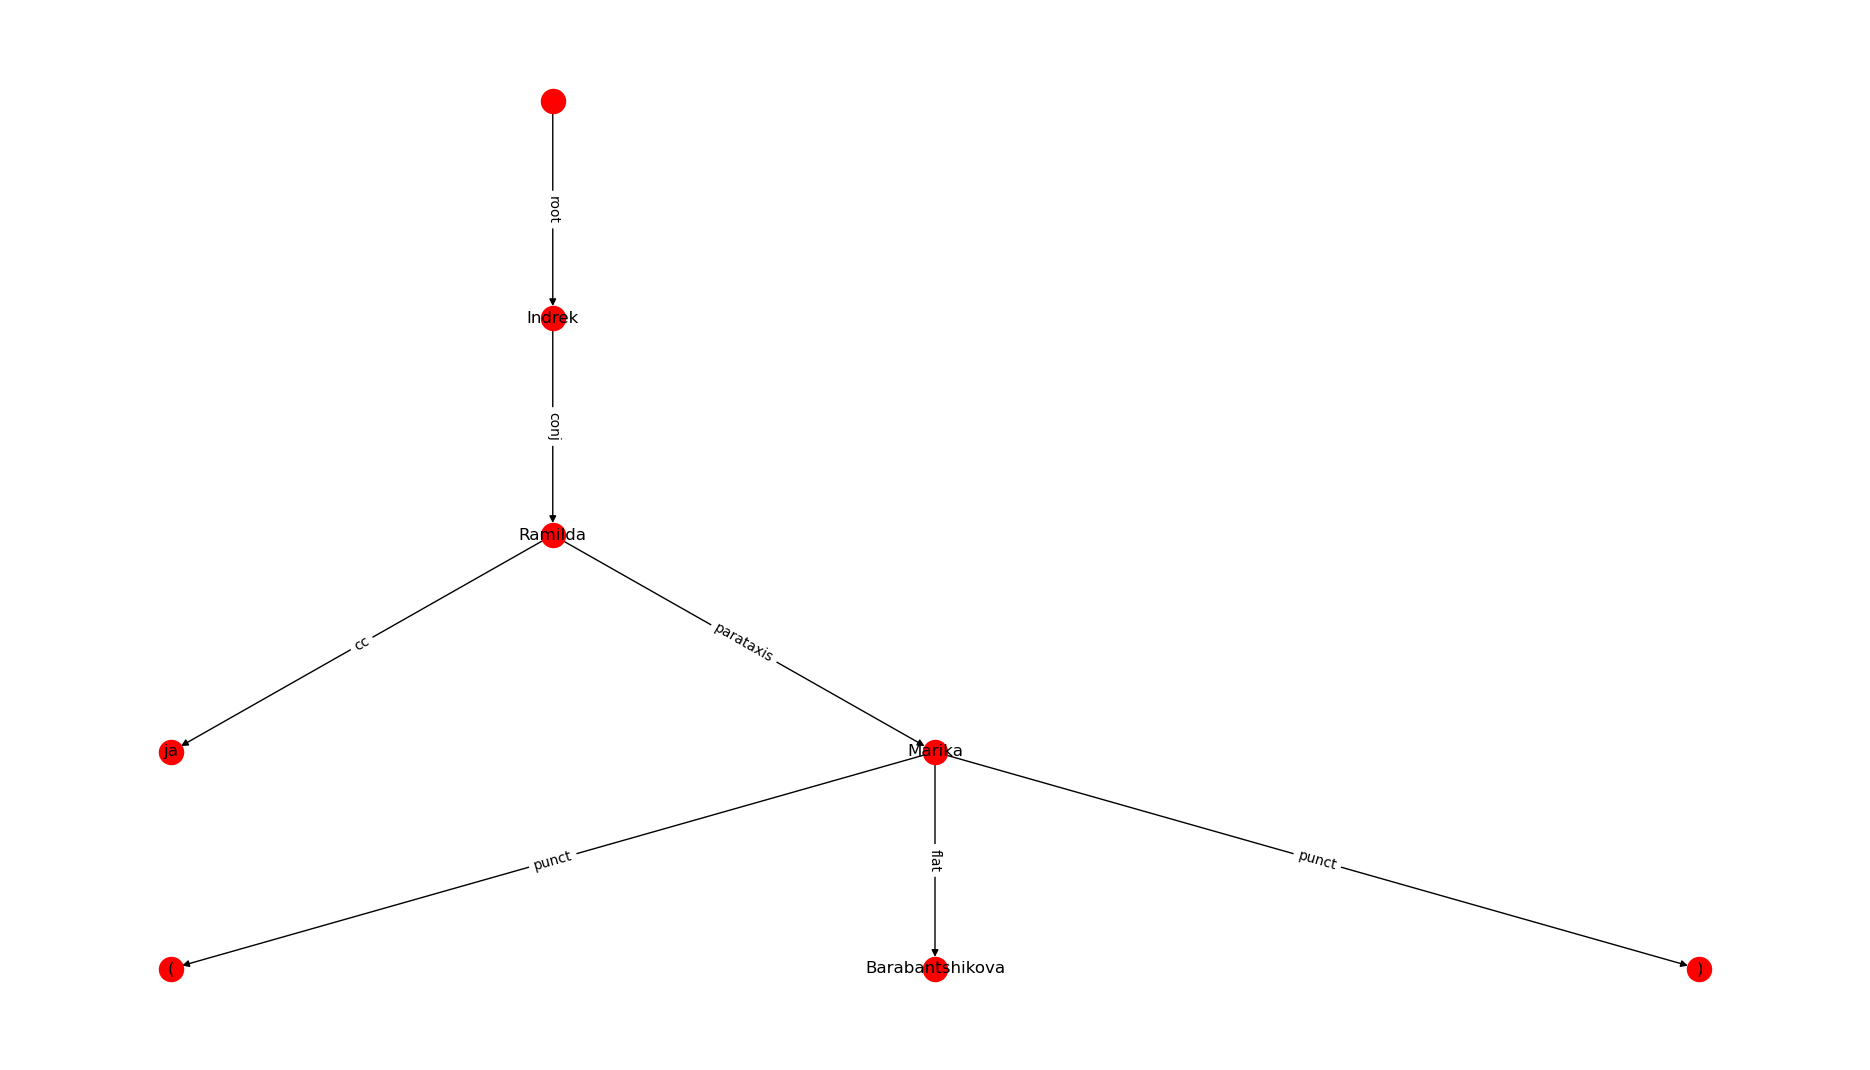

<Figure size 1850x1050 with 0 Axes>

In [30]:
# Visualiseerimine
draw_graph(test_graph, 'lemma')

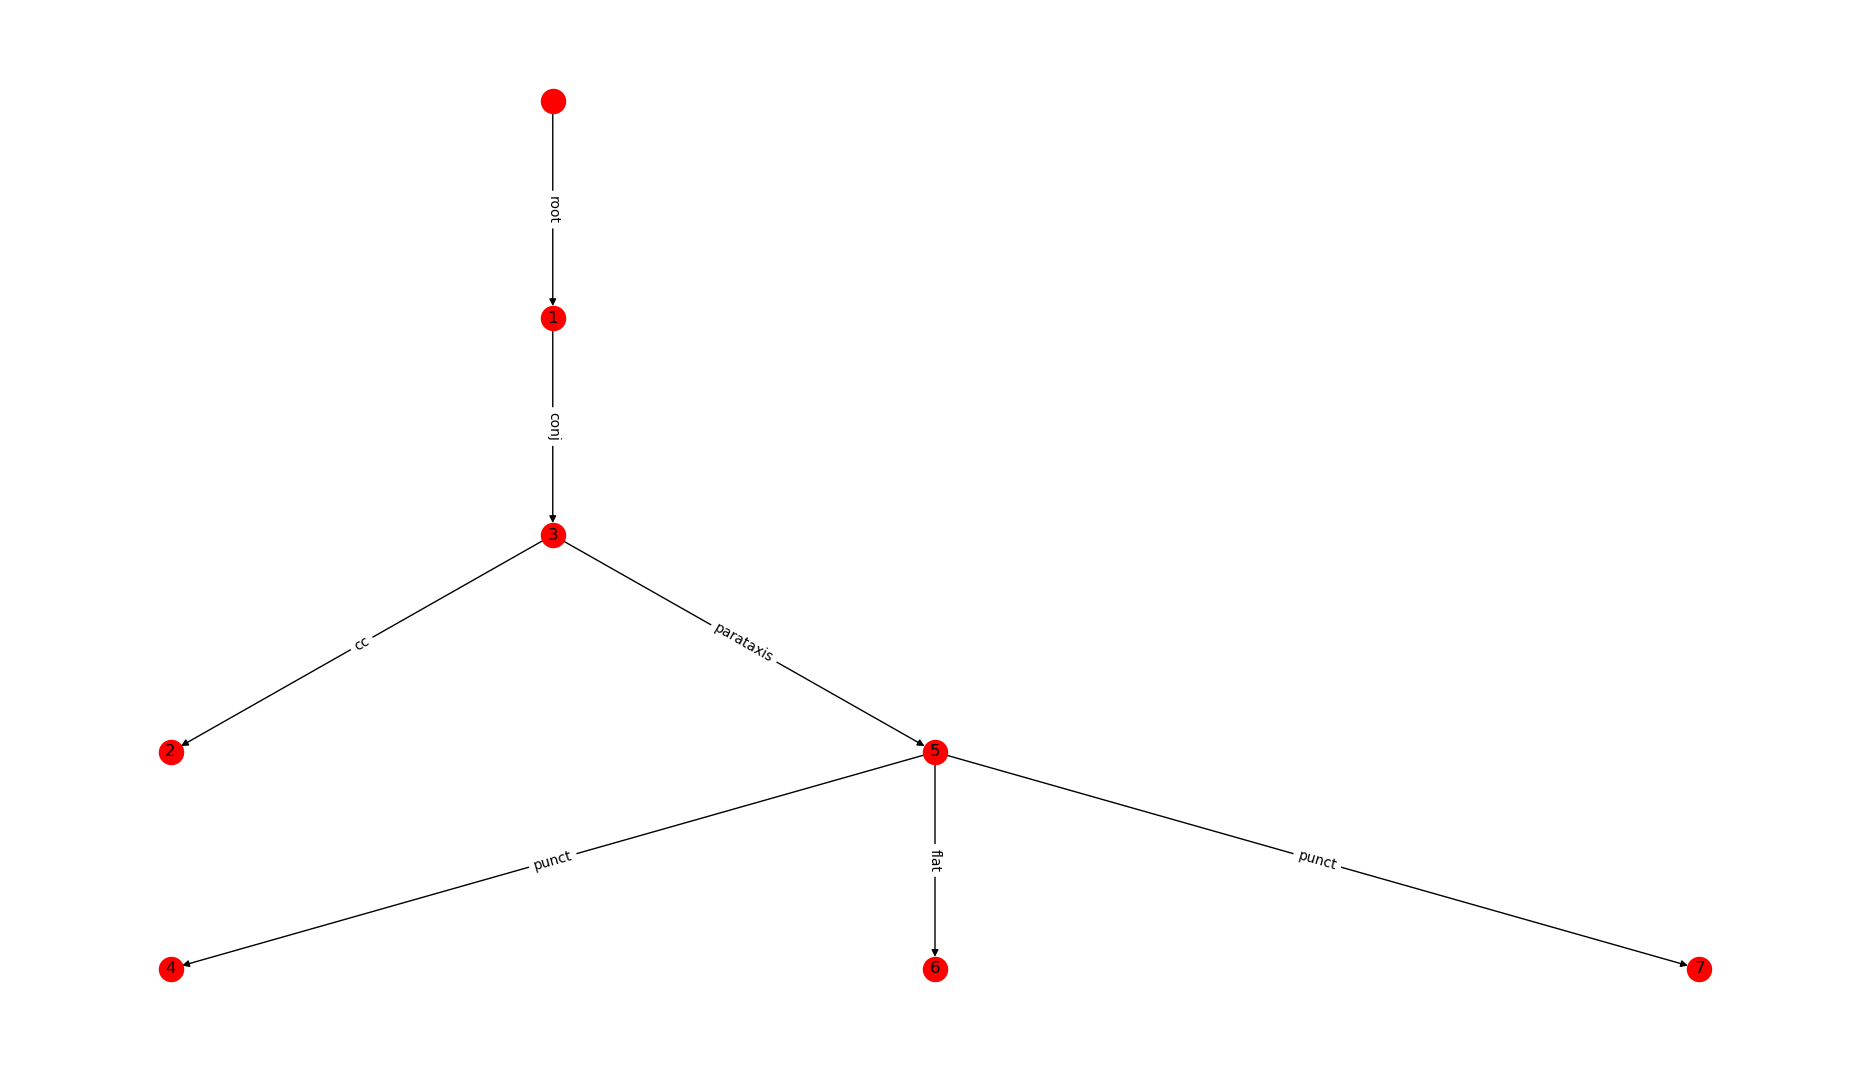

<Figure size 1850x1050 with 0 Axes>

In [31]:
draw_graph(test_graph_with_ids, 'id')

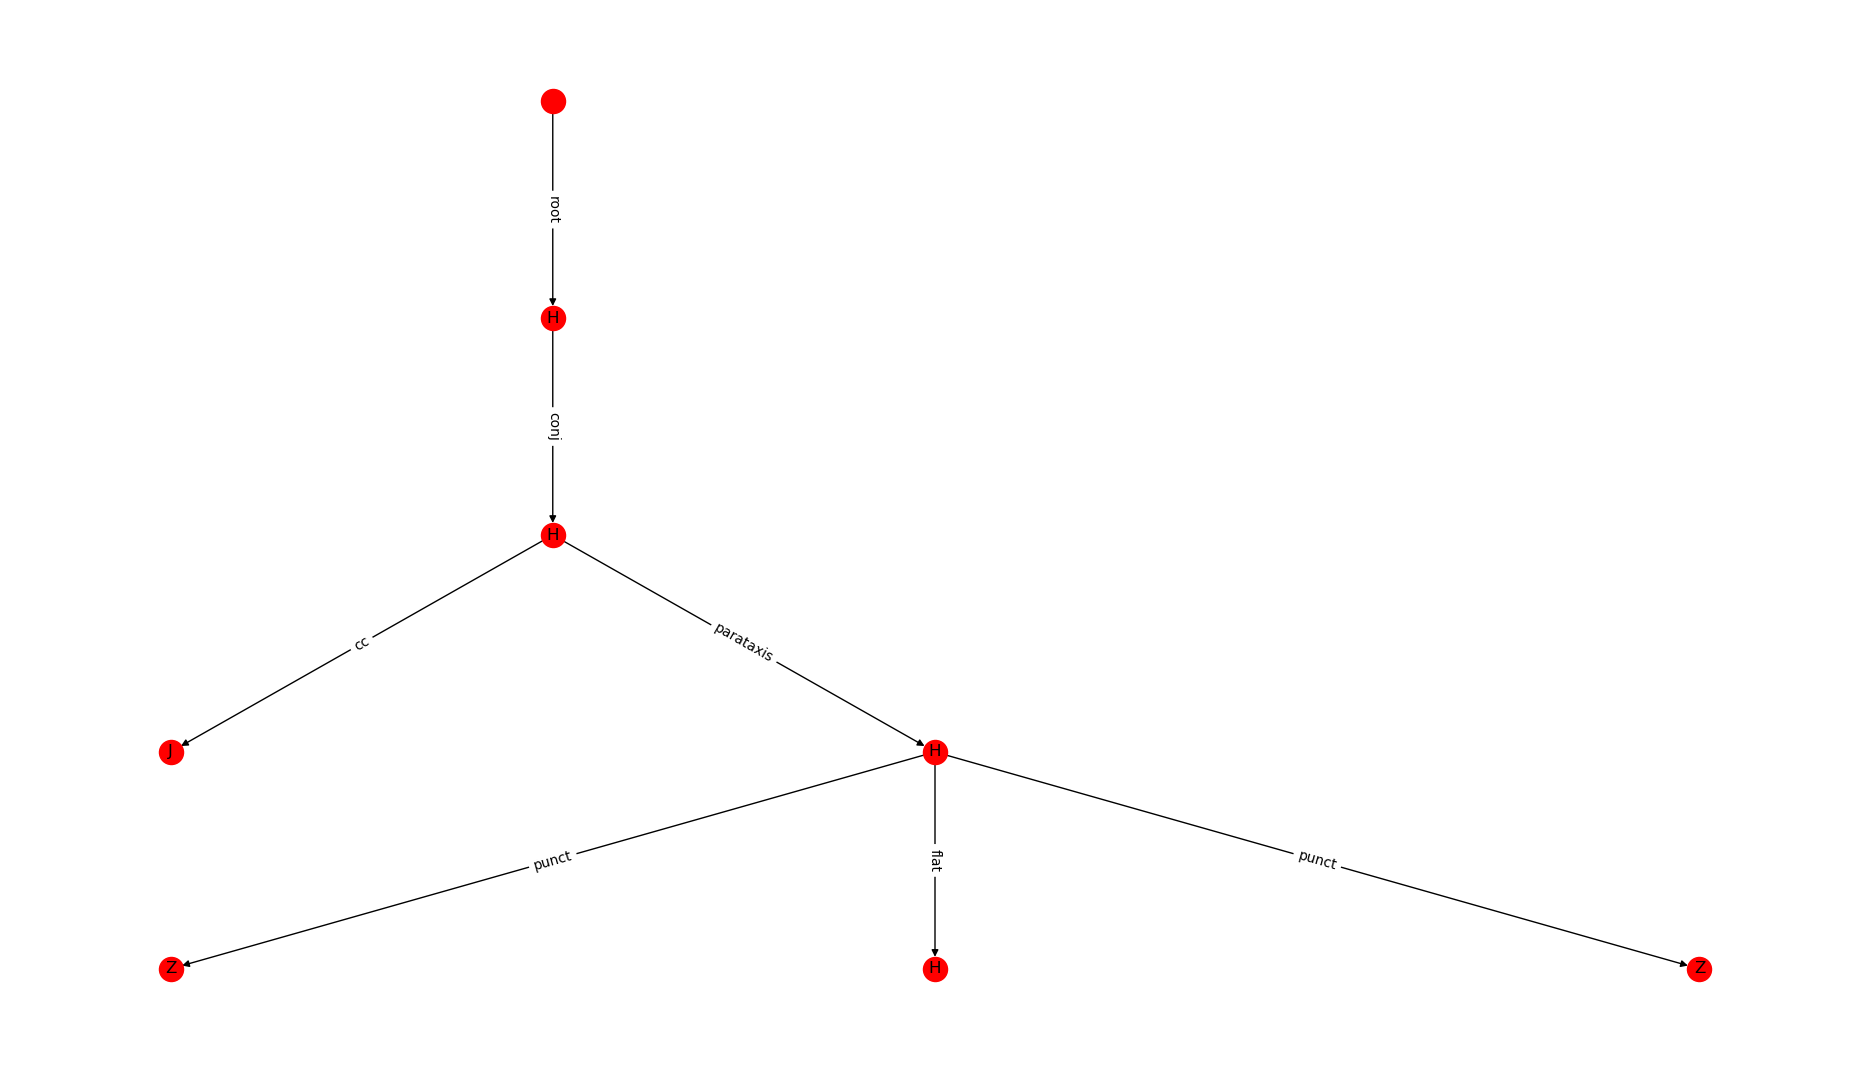

<Figure size 1850x1050 with 0 Axes>

In [32]:
draw_graph(test_graph_with_pos, 'pos')

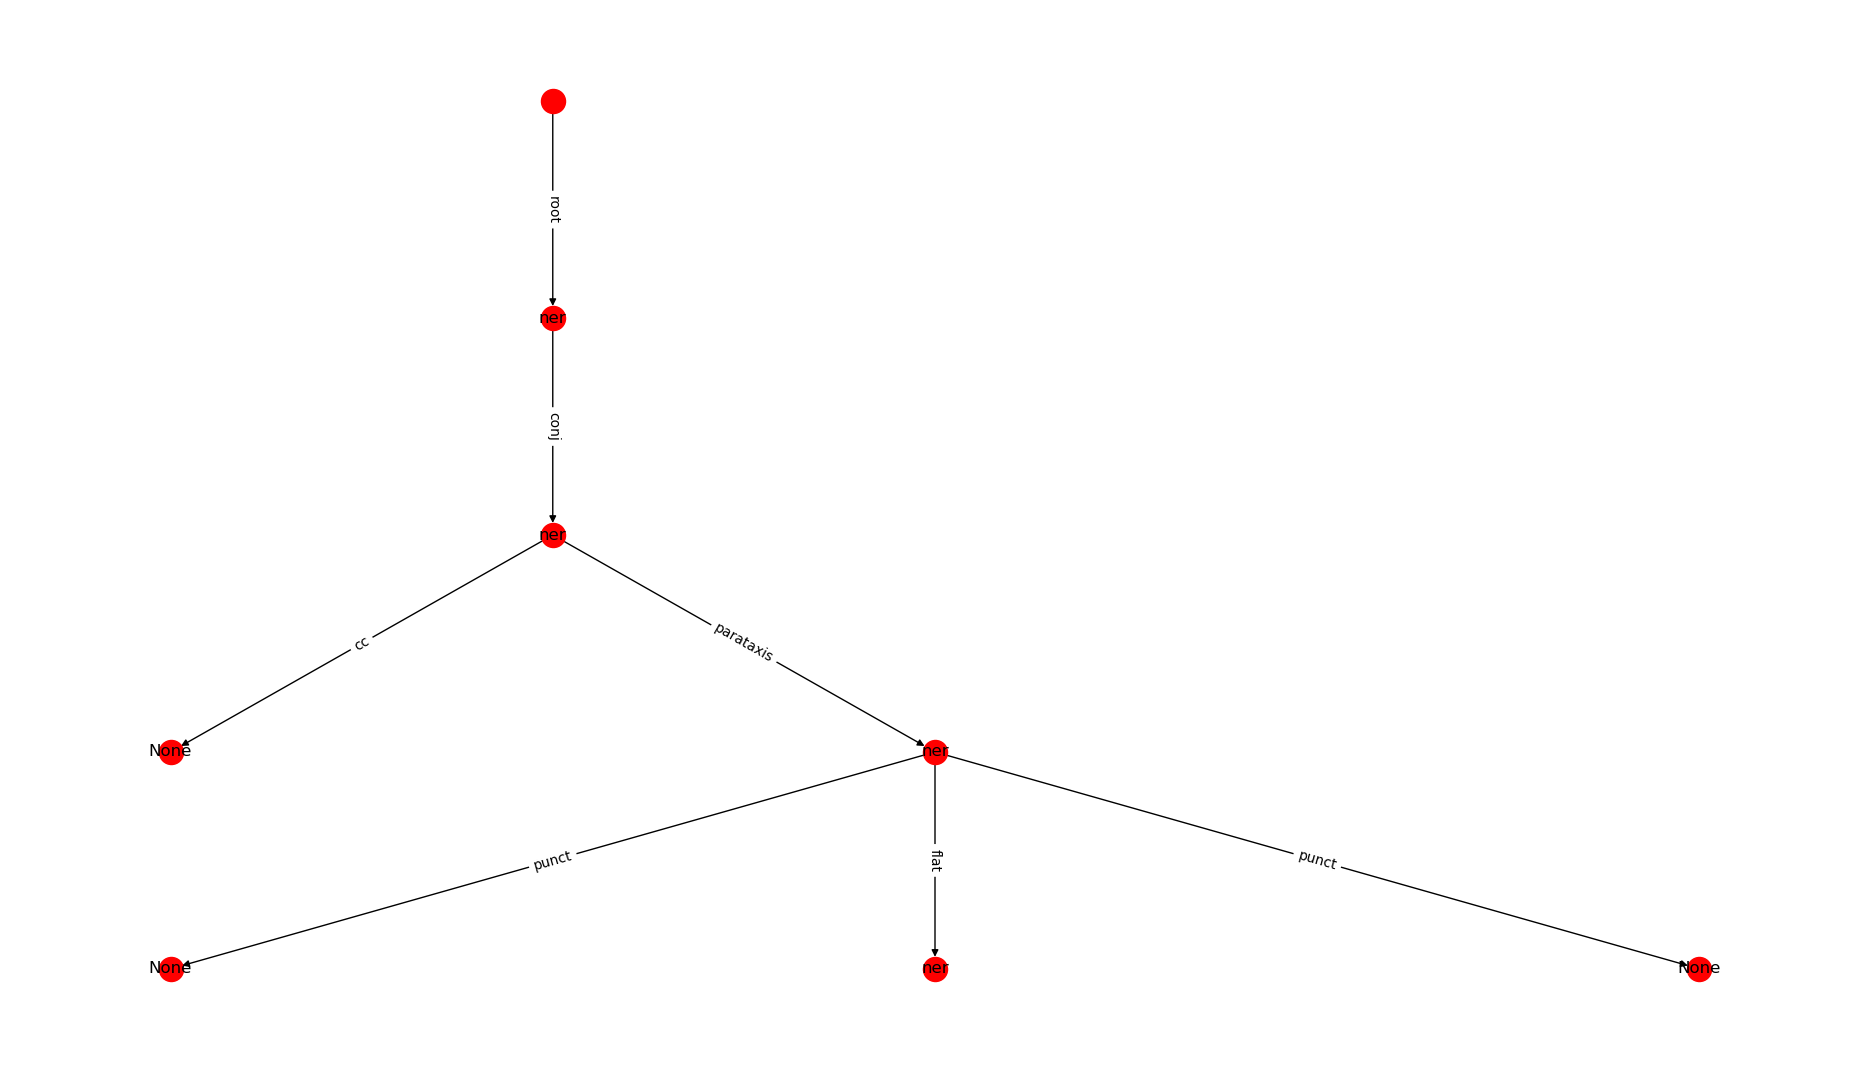

<Figure size 1850x1050 with 0 Axes>

In [33]:
draw_graph(test_graph_with_ner_timex, 'ner_timex')

Graafid ka DataFrame-i:

In [34]:
graphs_all = []
graphs_id = []
graphs_pos = []
graphs_ner_timex = []
for phrase in df['phrase']:
    graph1 = create_graph_with_all_attributes(phrase)
    graph2 = create_graph_with_ids(phrase)
    graph3 = create_graph_with_POS(phrase)
    graph4 = create_graph_with_ner_timex(phrase)
    graphs_all.append(graph1)
    graphs_id.append(graph2)
    graphs_pos.append(graph3)
    graphs_ner_timex.append(graph4)
df.insert(len(df.columns), 'graph_all_attr', graphs_all)
df.insert(len(df.columns), 'graph_id_only', graphs_id)
df.insert(len(df.columns), 'graph_id_pos', graphs_pos)
df.insert(len(df.columns), 'graph_id_ner_timex', graphs_ner_timex)

In [35]:
df

,phrase,text_id,start_end,phrase_type,has_ner_entity,has_timex_entity,pos_sequence,graph_all_attr,graph_id_only,graph_id_pos,graph_id_ner_timex
0,Text(text='Minu'),0,"(25, 29)",obl_phrase,0,0,P,"(1, 0)","(1, 0)","(1, 0)","(1, 0)"
1,Text(text='täiesti õigel kohal'),0,"(119, 138)",obl_phrase,0,0,D-A-S-,"(1, 2, 3, 0)","(1, 2, 3, 0)","(1, 2, 3, 0)","(1, 2, 3, 0)"
2,Text(text='mille kohaselt'),0,"(187, 201)",obl_phrase,0,0,P-K,"(1, 0, 2)","(1, 0, 2)","(1, 0, 2)","(1, 0, 2)"
3,Text(text='parlamenti'),0,"(210, 220)",obl_phrase,0,0,S,"(1, 0)","(1, 0)","(1, 0)","(1, 0)"
4,Text(text='valimistel'),0,"(326, 336)",obl_phrase,0,0,S,"(1, 0)","(1, 0)","(1, 0)","(1, 0)"
...,...,...,...,...,...,...,...,...,...,...,...
25128,"Text(text='See on puhas strateegiline küsimus - kui ma suudan anda teatrile natukene raha , siis lavastajatel on seda suurem võimalus eksida .')",145,"(3220, 3351)",root_phrase,0,0,P-V-A-A-S-Z-(J|D)-P-V-V-S-D-S-Z-J-S-V-P-C-S-V-Z,"(1, 5, 2, 3, 4, 0, 6, 9, 7, 8, 16, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22)","(1, 5, 2, 3, 4, 0, 6, 9, 7, 8, 16, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22)","(1, 5, 2, 3, 4, 0, 6, 9, 7, 8, 16, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22)","(1, 5, 2, 3, 4, 0, 6, 9, 7, 8, 16, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22)"
25129,Text(text='Eestis on harilikult kombeks sõita mõnele festivalile .'),145,"(4353, 4408)",root_phrase,1,0,H-V-D-S-V-P-S-Z,"(1, 4, 2, 3, 0, 5, 6, 7, 8)","(1, 4, 2, 3, 0, 5, 6, 7, 8)","(1, 4, 2, 3, 0, 5, 6, 7, 8)","(1, 4, 2, 3, 0, 5, 6, 7, 8)"
25130,Text(text='Aga publikule ?'),145,"(4692, 4707)",root_phrase,0,0,J-S-Z,"(1, 2, 0, 3)","(1, 2, 0, 3)","(1, 2, 0, 3)","(1, 2, 0, 3)"
25131,"Text(text='Minu meelest on see irdidee , et me kohutavalt müüma hakkame .')",145,"(4734, 4796)",root_phrase,0,0,P-K-V-P-S-Z-J-P-D-V-V-Z,"(1, 5, 2, 3, 4, 0, 6, 11, 7, 8, 9, 10, 12)","(1, 5, 2, 3, 4, 0, 6, 11, 7, 8, 9, 10, 12)","(1, 5, 2, 3, 4, 0, 6, 11, 7, 8, 9, 10, 12)","(1, 5, 2, 3, 4, 0, 6, 11, 7, 8, 9, 10, 12)"


Kas graaf on hashable?

In [36]:
df.duplicated(subset=['graph_all_attr'], keep=False)

0        False
1        False
2        False
3        False
4        False
         ...  
25128    False
25129    False
25130    False
25131    False
25132    False
Length: 25133, dtype: bool

Kuna ei tulnud error, siis on hashable.

### DataFrame-i salvestamine

In [37]:
df.to_pickle("./noun_phrase_data.pkl") 

In [38]:
df = pd.read_pickle("./noun_phrase_data.pkl")
df

,phrase,text_id,start_end,phrase_type,has_ner_entity,has_timex_entity,pos_sequence,graph_all_attr,graph_id_only,graph_id_pos,graph_id_ner_timex
0,Text(text='Minu'),0,"(25, 29)",obl_phrase,0,0,P,"(1, 0)","(1, 0)","(1, 0)","(1, 0)"
1,Text(text='täiesti õigel kohal'),0,"(119, 138)",obl_phrase,0,0,D-A-S-,"(1, 2, 3, 0)","(1, 2, 3, 0)","(1, 2, 3, 0)","(1, 2, 3, 0)"
2,Text(text='mille kohaselt'),0,"(187, 201)",obl_phrase,0,0,P-K,"(1, 0, 2)","(1, 0, 2)","(1, 0, 2)","(1, 0, 2)"
3,Text(text='parlamenti'),0,"(210, 220)",obl_phrase,0,0,S,"(1, 0)","(1, 0)","(1, 0)","(1, 0)"
4,Text(text='valimistel'),0,"(326, 336)",obl_phrase,0,0,S,"(1, 0)","(1, 0)","(1, 0)","(1, 0)"
...,...,...,...,...,...,...,...,...,...,...,...
25128,"Text(text='See on puhas strateegiline küsimus - kui ma suudan anda teatrile natukene raha , siis lavastajatel on seda suurem võimalus eksida .')",145,"(3220, 3351)",root_phrase,0,0,P-V-A-A-S-Z-(J|D)-P-V-V-S-D-S-Z-J-S-V-P-C-S-V-Z,"(1, 5, 2, 3, 4, 0, 6, 9, 7, 8, 16, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22)","(1, 5, 2, 3, 4, 0, 6, 9, 7, 8, 16, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22)","(1, 5, 2, 3, 4, 0, 6, 9, 7, 8, 16, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22)","(1, 5, 2, 3, 4, 0, 6, 9, 7, 8, 16, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22)"
25129,Text(text='Eestis on harilikult kombeks sõita mõnele festivalile .'),145,"(4353, 4408)",root_phrase,1,0,H-V-D-S-V-P-S-Z,"(1, 4, 2, 3, 0, 5, 6, 7, 8)","(1, 4, 2, 3, 0, 5, 6, 7, 8)","(1, 4, 2, 3, 0, 5, 6, 7, 8)","(1, 4, 2, 3, 0, 5, 6, 7, 8)"
25130,Text(text='Aga publikule ?'),145,"(4692, 4707)",root_phrase,0,0,J-S-Z,"(1, 2, 0, 3)","(1, 2, 0, 3)","(1, 2, 0, 3)","(1, 2, 0, 3)"
25131,"Text(text='Minu meelest on see irdidee , et me kohutavalt müüma hakkame .')",145,"(4734, 4796)",root_phrase,0,0,P-K-V-P-S-Z-J-P-D-V-V-Z,"(1, 5, 2, 3, 4, 0, 6, 11, 7, 8, 9, 10, 12)","(1, 5, 2, 3, 4, 0, 6, 11, 7, 8, 9, 10, 12)","(1, 5, 2, 3, 4, 0, 6, 11, 7, 8, 9, 10, 12)","(1, 5, 2, 3, 4, 0, 6, 11, 7, 8, 9, 10, 12)"


### Histogramm fraasi pikkuste jagunemisest (sõnades)

In [39]:
# eri fraasitüüpide kohta eraldi histogrammid

In [40]:
all_phrase_lengths = np.array([len(df['phrase'][i].words) for i in range(len(df))])

obl_phrase_lengths = np.array([len(df['phrase'][i].words) for i in range(len(df)) 
                               if df['phrase_type'][i]=='obl_phrase'])

nsubj_phrase_lengths = np.array([len(df['phrase'][i].words) for i in range(len(df)) 
                                 if df['phrase_type'][i]=='nsubj_phrase'])

nsubj_cop_phrase_lengths = np.array([len(df['phrase'][i].words) for i in range(len(df)) 
                                     if df['phrase_type'][i]=='nsubj_cop_phrase'])

obj_phrase_lengths = np.array([len(df['phrase'][i].words) for i in range(len(df)) 
                               if df['phrase_type'][i]=='obj_phrase'])

xcomp_phrase_lengths = np.array([len(df['phrase'][i].words) for i in range(len(df)) 
                                 if df['phrase_type'][i]=='xcomp_phrase'])

nmod_phrase_lengths = np.array([len(df['phrase'][i].words) for i in range(len(df)) 
                                 if df['phrase_type'][i]=='nmod_phrase'])

appos_phrase_lengths = np.array([len(df['phrase'][i].words) for i in range(len(df)) 
                                 if df['phrase_type'][i]=='appos_phrase'])

parataxis_phrase_lengths = np.array([len(df['phrase'][i].words) for i in range(len(df)) 
                                 if df['phrase_type'][i]=='parataxis_phrase'])

root_phrase_lengths = np.array([len(df['phrase'][i].words) for i in range(len(df)) 
                                 if df['phrase_type'][i]=='root_phrase'])

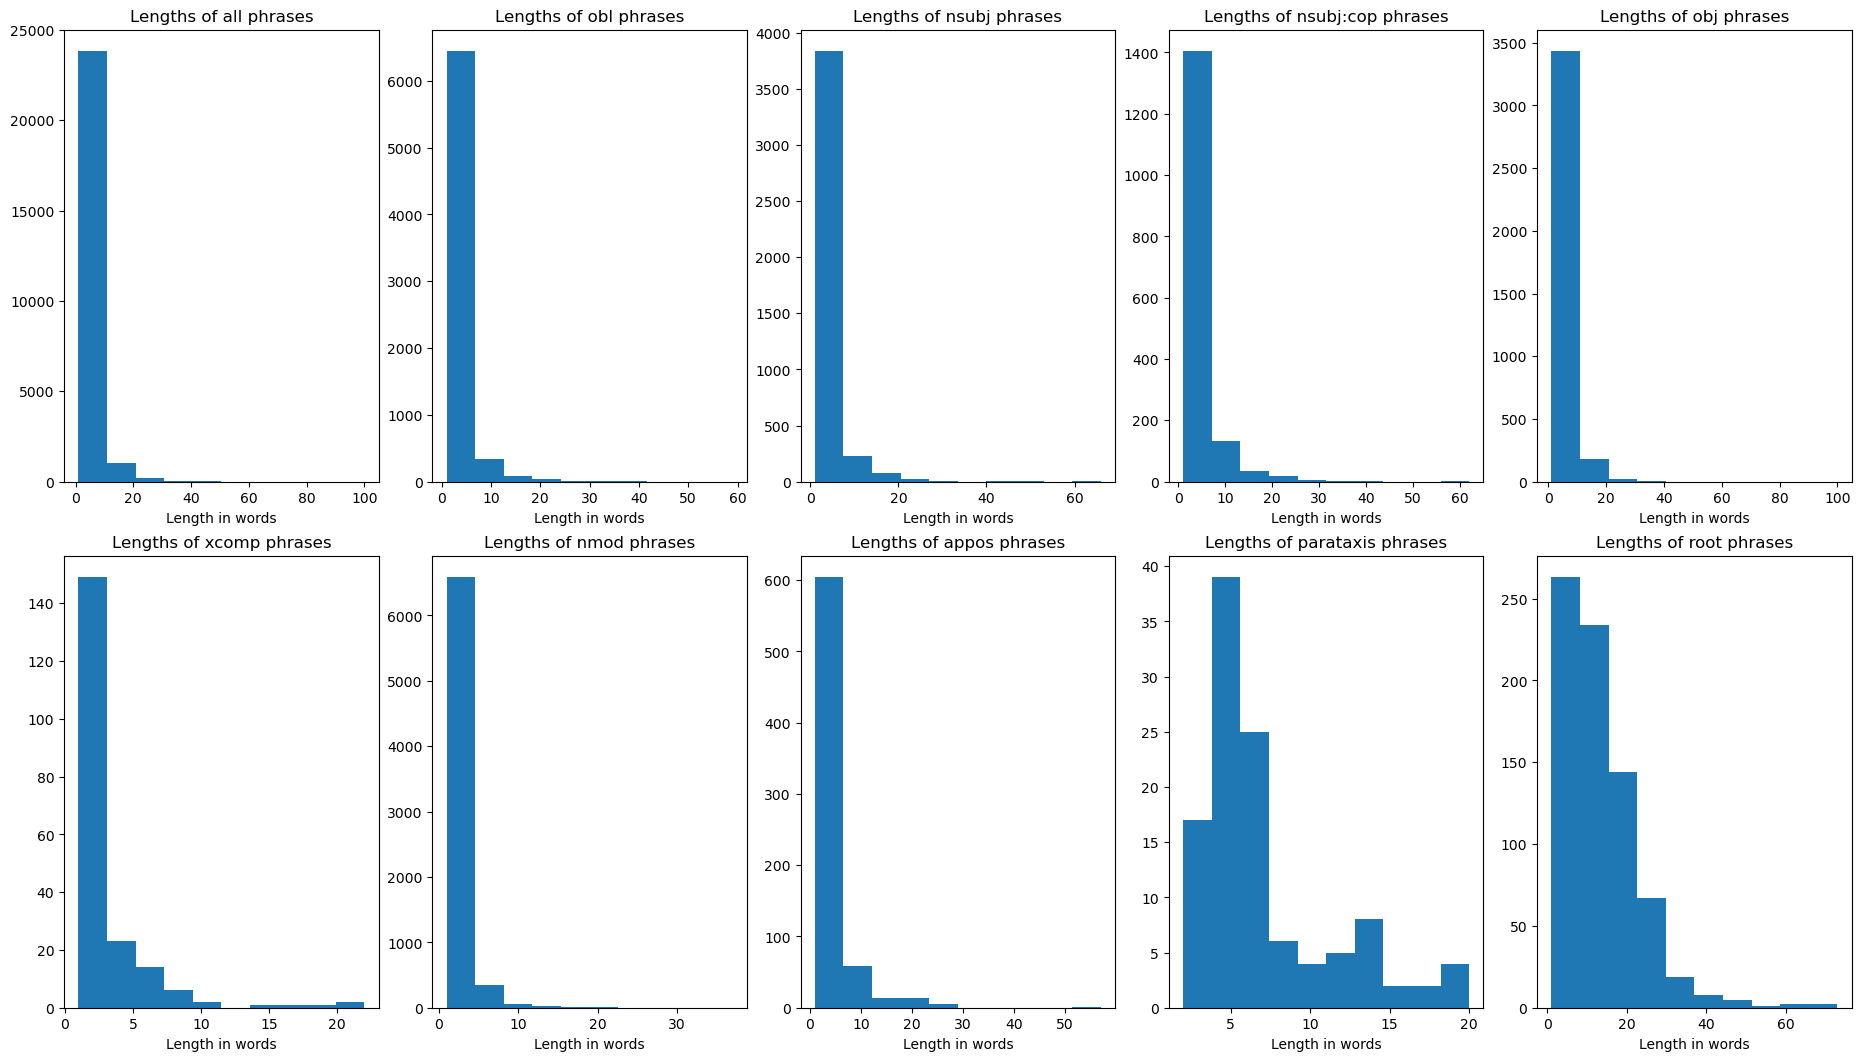

In [41]:
fig, ((ax1, ax2, ax3, ax4, ax5), (ax6, ax7, ax8, ax9, ax10)) = plt.subplots(2, 5, constrained_layout=True)
ax1.set_title('Lengths of all phrases')
ax1.set_xlabel('Length in words')
ax1.hist(all_phrase_lengths)
ax2.set_title('Lengths of obl phrases')
ax2.set_xlabel('Length in words')
ax2.hist(obl_phrase_lengths)
ax3.set_title('Lengths of nsubj phrases')
ax3.set_xlabel('Length in words')
ax3.hist(nsubj_phrase_lengths)
ax4.set_title('Lengths of nsubj:cop phrases')
ax4.set_xlabel('Length in words')
ax4.hist(nsubj_cop_phrase_lengths)
ax5.set_title('Lengths of obj phrases')
ax5.set_xlabel('Length in words')
ax5.hist(obj_phrase_lengths)
ax6.set_title('Lengths of xcomp phrases')
ax6.set_xlabel('Length in words')
ax6.hist(xcomp_phrase_lengths)
ax7.set_title('Lengths of nmod phrases')
ax7.set_xlabel('Length in words')
ax7.hist(nmod_phrase_lengths)
ax8.set_title('Lengths of appos phrases')
ax8.set_xlabel('Length in words')
ax8.hist(appos_phrase_lengths)
ax9.set_title('Lengths of parataxis phrases')
ax9.set_xlabel('Length in words')
ax9.hist(parataxis_phrase_lengths)
ax10.set_title('Lengths of root phrases')
ax10.set_xlabel('Length in words')
ax10.hist(root_phrase_lengths)
plt.show()

### Groupby() graafidel

In [42]:
# katsetamiseks kaks identset ja üks erinev graaf
test_graph = df['graph_id_only'][0]
test_graph2 = df['graph_id_only'][0]
test_graph3 = df['graph_id_only'][2]
test_graph

In [43]:
test_graph4 = df['graph_id_pos'][0]
test_graph5 = df['graph_id_pos'][0]
test_graph6 = df['graph_id_pos'][2]

In [44]:
test_graph7 = df['graph_id_ner_timex'][0]
test_graph8 = df['graph_id_ner_timex'][0]
test_graph9 = df['graph_id_ner_timex'][4]

Tippudes olevate atribuutide väärtused listidena. Tundub, et tuleb ükshaaval küsida.

In [45]:
list(test_graph.nodes(data='id'))

[(1, 1), (0, None)]

In [46]:
print(list(test_graph4.nodes(data='id')))
print(list(test_graph4.nodes(data='pos')))

[(1, 1), (0, None)]
[(1, 'P'), (0, None)]


In [47]:
print(list(test_graph9.nodes(data='id')))
print(list(test_graph9.nodes(data='ner_timex')))

[(1, 1), (0, None)]
[(1, None), (0, None)]


Pandase groupby() ei saa võrrelda kaht graafi otse. Seetõttu peab valima võrdluse aluseks graafi atribuudid.

In [48]:
# funktsioon tipuatribuutide väärtuste saamiseks
def get_node_data(graph, data):
    # return "-".join([str(node[1]) if node[1] is not None else "0" for node in graph.nodes(data=data)])
    return "-".join([str(node[1]) for node in graph.nodes(data=data)])

Tehakse uued tulbad, kus on graafi eri atribuudijärjestused sõnedena. Nende järgi toimubki hiljem grupeerimine.

In [49]:
df['graph_id_str'] = [get_node_data(graph, 'id') for graph in df['graph_id_only']]

In [50]:
df['graph_pos_str'] = [get_node_data(graph, 'pos') for graph in df['graph_id_pos']]

In [51]:
df['graph_ner_timex_str'] = [get_node_data(graph, 'ner_timex') for graph in df['graph_id_ner_timex']]

In [52]:
df.to_pickle("./noun_phrase_data.pkl") 

In [53]:
df = pd.read_pickle("./noun_phrase_data.pkl")
df

,phrase,text_id,start_end,phrase_type,has_ner_entity,has_timex_entity,pos_sequence,graph_all_attr,graph_id_only,graph_id_pos,graph_id_ner_timex,graph_id_str,graph_pos_str,graph_ner_timex_str
0,Text(text='Minu'),0,"(25, 29)",obl_phrase,0,0,P,"(1, 0)","(1, 0)","(1, 0)","(1, 0)",1-None,P-None,None-None
1,Text(text='täiesti õigel kohal'),0,"(119, 138)",obl_phrase,0,0,D-A-S-,"(1, 2, 3, 0)","(1, 2, 3, 0)","(1, 2, 3, 0)","(1, 2, 3, 0)",1-2-3-None,D-A-S-None,None-None-None-None
2,Text(text='mille kohaselt'),0,"(187, 201)",obl_phrase,0,0,P-K,"(1, 0, 2)","(1, 0, 2)","(1, 0, 2)","(1, 0, 2)",1-None-2,P-None-K,None-None-None
3,Text(text='parlamenti'),0,"(210, 220)",obl_phrase,0,0,S,"(1, 0)","(1, 0)","(1, 0)","(1, 0)",1-None,S-None,None-None
4,Text(text='valimistel'),0,"(326, 336)",obl_phrase,0,0,S,"(1, 0)","(1, 0)","(1, 0)","(1, 0)",1-None,S-None,None-None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25128,"Text(text='See on puhas strateegiline küsimus - kui ma suudan anda teatrile natukene raha , siis lavastajatel on seda suurem võimalus eksida .')",145,"(3220, 3351)",root_phrase,0,0,P-V-A-A-S-Z-(J|D)-P-V-V-S-D-S-Z-J-S-V-P-C-S-V-Z,"(1, 5, 2, 3, 4, 0, 6, 9, 7, 8, 16, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22)","(1, 5, 2, 3, 4, 0, 6, 9, 7, 8, 16, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22)","(1, 5, 2, 3, 4, 0, 6, 9, 7, 8, 16, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22)","(1, 5, 2, 3, 4, 0, 6, 9, 7, 8, 16, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22)",1-5-2-3-4-None-6-9-7-8-16-10-11-12-13-14-15-17-18-19-20-21-22,P-S-V-A-A-None-Z-V-J|D-P-S-V-S-D-S-Z-J-V-P-C-S-V-Z,None-None-None-None-None-None-None-None-None-None-None-None-None-None-None-None-None-None-None-None-None-None-None
25129,Text(text='Eestis on harilikult kombeks sõita mõnele festivalile .'),145,"(4353, 4408)",root_phrase,1,0,H-V-D-S-V-P-S-Z,"(1, 4, 2, 3, 0, 5, 6, 7, 8)","(1, 4, 2, 3, 0, 5, 6, 7, 8)","(1, 4, 2, 3, 0, 5, 6, 7, 8)","(1, 4, 2, 3, 0, 5, 6, 7, 8)",1-4-2-3-None-5-6-7-8,H-S-V-D-None-V-P-S-Z,ner-None-None-None-None-None-None-None-None
25130,Text(text='Aga publikule ?'),145,"(4692, 4707)",root_phrase,0,0,J-S-Z,"(1, 2, 0, 3)","(1, 2, 0, 3)","(1, 2, 0, 3)","(1, 2, 0, 3)",1-2-None-3,J-S-None-Z,None-None-None-None
25131,"Text(text='Minu meelest on see irdidee , et me kohutavalt müüma hakkame .')",145,"(4734, 4796)",root_phrase,0,0,P-K-V-P-S-Z-J-P-D-V-V-Z,"(1, 5, 2, 3, 4, 0, 6, 11, 7, 8, 9, 10, 12)","(1, 5, 2, 3, 4, 0, 6, 11, 7, 8, 9, 10, 12)","(1, 5, 2, 3, 4, 0, 6, 11, 7, 8, 9, 10, 12)","(1, 5, 2, 3, 4, 0, 6, 11, 7, 8, 9, 10, 12)",1-5-2-3-4-None-6-11-7-8-9-10-12,P-S-K-V-P-None-Z-V-J-P-D-V-Z,None-None-None-None-None-None-None-None-None-None-None-None-None


Grupeerides ainult ID-de alusel:

In [54]:
# grupeerides ainul ID-de alusel
grouped_df2 = df.groupby('graph_id_str')

In [55]:
grouped_df2.describe()
# eri gruppe 1768

phrase  \
                                                                                                                                          count   
graph_id_str                                                                                                                                      
1-10-2-3-4-5-6-7-8-9-None                                                                                                                     1   
1-10-2-3-4-5-6-7-9-8-None                                                                                                                     1   
1-10-2-3-4-5-7-6-8-9-46-11-12-13-14-15-16-36-17-18-19-20-21-22-23-24-25-26-27-28-29-30-31-32-33-34-35-37-38-39-40-41-42-43-44-45-None-47      1   
1-10-2-3-4-5-7-6-8-9-None                                                                                                                     1   
1-10-2-3-5-4-6-7-8-9-None-11-12-13                                                                                                            1   
...                                                                                                                                         ...   
1-None-2-9-3-4-5-6-7-8-10-11-12-13-14-15-16                                                                                                   1   
1-None-2-9-3-4-5-6-7-8-10-11-12-13-14-15-17-16                                                                                                1   
1-None-2-9-3-4-5-6-7-8-10-11-12-14-13-15-16                                                                                                   1   
1-None-2-9-3-4-6-5-7-8-10-11-12-13-14                                                                                                         1   
1-None-2-9-3-4-6-5-7-8-10-11-12-13-14-16-15-17-18-19-20-21-22-23                                                                              1   

                                                                                                                                                 \
                                                                                                                                         unique   
graph_id_str                                                                                                                                      
1-10-2-3-4-5-6-7-8-9-None                                                                                                                     1   
1-10-2-3-4-5-6-7-9-8-None                                                                                                                     1   
1-10-2-3-4-5-7-6-8-9-46-11-12-13-14-15-16-36-17-18-19-20-21-22-23-24-25-26-27-28-29-30-31-32-33-34-35-37-38-39-40-41-42-43-44-45-None-47      1   
1-10-2-3-4-5-7-6-8-9-None                                                                                                                     1   
1-10-2-3-5-4-6-7-8-9-None-11-12-13                                                                                                            1   
...                                                                                                                                         ...   
1-None-2-9-3-4-5-6-7-8-10-11-12-13-14-15-16                                                                                                   1   
1-None-2-9-3-4-5-6-7-8-10-11-12-13-14-15-17-16                                                                                                1   
1-None-2-9-3-4-5-6-7-8-10-11-12-14-13-15-16                                                                                                   1   
1-None-2-9-3-4-6-5-7-8-10-11-12-13-14                                                                                                         1   
1-None-2-9-3-4-6-5-7-8-10-11-12-13-14-16-15-17-18-19-20-21-22-23                                                                              1   

                   

Grupeerides ID-de ja POS-järjestuste alusel:

In [56]:
# grupeerides ID-de ja POS-järjestuste alusel
grouped_df3 = df.groupby(['graph_id_str', 'graph_pos_str'])

In [57]:
grouped_df3.describe()
# eri gruppe 4817

phrase  \
                                                                                                                                                                                                                                               count   
graph_id_str                                                                                                                             graph_pos_str                                                                                                 
1-10-2-3-4-5-6-7-8-9-None                                                                                                                Z-S-S-Z-S-Z-S-J-S-Z-None                                                                                  1   
1-10-2-3-4-5-6-7-9-8-None                                                                                                                A-S-S-Z-S-Z-Y-J-H-H-None                                                                                  1   
1-10-2-3-4-5-7-6-8-9-46-11-12-13-14-15-16-36-17-18-19-20-21-22-23-24-25-26-27-28-29-30-31-32-33-34-35-37-38-39-40-41-42-43-44-45-None-47 J-V-S-K-V-N-S-S-N-S-S-D-D-S-Z-V-Z-A|V-J-S-H-H-Z-H-H-Z-H-H-Z-H-H-J-H-H-V-P-D-Y-S-Z-Z-Z-V-S-P-D-None-Z      1   
1-10-2-3-4-5-7-6-8-9-None                                                                                                                H-S-J-H-Z-D-H-H-A-S-None                                                                                  1   
1-10-2-3-5-4-6-7-8-9-None-11-12-13                                                                                                       H-V-S-Z-V-J-D-S-N-Z-None-D-V-Z                                                                            1   
...                                                                                                                                                                                                                                              ...   
1-None-2-9-3-4-5-6-7-8-10-11-12-13-14-15-16                                                                                              P-None-Z-V-P-H-H-S-K-V-Z-S-Z-S-Z-S-Z                                                                      1   
1-None-2-9-3-4-5-6-7-8-10-11-12-13-14-15-17-16                                                                                           S-None-Z-V-P-P-D-A-J-A-Z-V-S-S-K-S-S-H                                                                    1   
1-None-2-9-3-4-5-6-7-8-10-11-12-14-13-15-16                                                                                              S-None-Z-V|A-P-D-S-K-S-K-Z-S-Z-H-D-J-S                                                                    1   
1-None-2-9-3-4-6-5-7-8-10-11-12-13-14                                                                                                    P-None-Z-V-J-D-C-D-S-K-S-D-H-S-Z                                                                          1   
1-None-2-9-3-4-6-5-7-8-10-11-12-13-14-16-15-17-18-19-20-21-22-23                                                                         S-None-Z-V-J-H-S-H-H-H-S-S-S-P-Z-V-J-D-K-S-H-G-S-V                                                        1   

                                                                                                                                                                                                                                                      \
                                                                                                                                                                                                                                              unique   
graph_id_str                                                                                                                             graph_pos_str                                                                                                 
1-10-2-3-4-5-6-7-8-9-

Grupeerides ID-de ja ner/timex entiteetide alusel:

In [58]:
# grupeerides ID-de ja ner/timex entiteetide alusel
grouped_df4 = df.groupby(['graph_id_str', 'graph_ner_timex_str'])

In [59]:
grouped_df4.describe()
# eri gruppe 2532

phrase  \
                                                                                                                                                                                                                                                                                                                                                                              count   
graph_id_str                                                                                                                             graph_ner_timex_str                                                                                                                                                                                                                          
1-10-2-3-4-5-6-7-8-9-None                                                                                                                None-None-None-None-None-None-None-None-None-None-None                                                                                                                                                                                   1   
1-10-2-3-4-5-6-7-9-8-None                                                                                                                None-None-None-None-None-None-ner-None-ner-ner-None                                                                                                                                                                                      1   
1-10-2-3-4-5-7-6-8-9-46-11-12-13-14-15-16-36-17-18-19-20-21-22-23-24-25-26-27-28-29-30-31-32-33-34-35-37-38-39-40-41-42-43-44-45-None-47 None-None-None-None-None-None-None-None-None-None-None-None-None-None-None-None-None-None-None-None-ner-ner-None-ner-ner-None-ner-ner-None-ner-ner-None-ner-ner-None-None-None-ner-ner-None-None-None-None-None-None-None-None-None      1   
1-10-2-3-4-5-7-6-8-9-None                                                                                                                ner-None-None-ner-None-None-ner-ner-None-None-None                                                                                                                                                                                       1   
1-10-2-3-5-4-6-7-8-9-None-11-12-13                                                                                                       ner-None-ner-None-None-None-timex-None-None-None-None-None-None-None                                                                                                                                                                     1   
...                                                                                                                                                                                                                                                                                                                                                                             ...   
1-None-2-9-3-4-5-6-7-8-10-11-12-13-14-15-16                                                                                              None-None-None-None-None-ner-ner-None-None-None-None-None-None-None-None-None-None                                                                                                                                                       1   
1-None-2-9-3-4-5-6-7-8-10-11-12-13-14-15-17-16                                                                                           None-None-None-None-None-None-None-None-None-None-None-None-None-None-None-None-None-ner                                                                                                                                                 1   
1-None-2-9-3-4-5-6-7-8-10-11-12-14-13-15-16                                                                                              None-None-None-None-None-None-None-None-None-None-None-None-None-ner-None-None-None                    

Grupid ja nende liikmed:

In [118]:
# grupeeritud ID-de ja ner/timex entiteetide alusel
#for name, group in grouped_df4:
#    display(name, group, len(group))

In [60]:
#for name, group in grouped_df4:
#    print(name, len(group))
#    print()